# Практическое задание по теме 5. Временные ряды
## Поиск аномалий и особенные случаи обработки

In [1]:
import numpy as np
import pandas as pd 
import random

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel
from sklearn.feature_selection import f_regression, mutual_info_regression

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
PATH = 'C:/Users/ASER/Desktop/GeekBrains/ML_in_business/Lesson_5/'

### Задание 1.
Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями.

In [4]:
file_name = 'my_BRENT2019.csv'
data = pd.read_csv(PATH + file_name, index_col=[0], parse_dates=[0]).sort_index()
print(data.shape)
data.head(2)

(2667, 11)


,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0


In [5]:
TARGET_NAME = 'Значение'

In [6]:
data.loc[1:, 'diff_1'] = data[TARGET_NAME][:-1].values - data[TARGET_NAME][1:].values
data.head(2)

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,diff_1
Дата,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0,NaN
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0,-0.52


### Задание 2.
Сделайте ее перрасчет (ресемплинг) в представление по неделям.

In [7]:
def plot_target(data, title_str, stat=True):
    if stat:
        DF_ct = sm.tsa.stattools.adfuller(data[TARGET_NAME].fillna(0).values, regression='ct')
        DF_ctt = sm.tsa.stattools.adfuller(data[TARGET_NAME].fillna(0).values, regression='ctt')
        print(f'Augmented Dickey–Fuller тест: {round(DF_ct[1], 3)}, {round(DF_ctt[1], 3)}') 
        
    (title, name_1) = title_str
    plt.figure(figsize =(20, 4))
    plt.plot( data.index, data[TARGET_NAME], 'b' )
    plt.title(title, size=14)
    plt.xlabel('Время')
    plt.ylabel(name_1)
    plt.show()

Augmented Dickey–Fuller тест: 0.331, 0.32


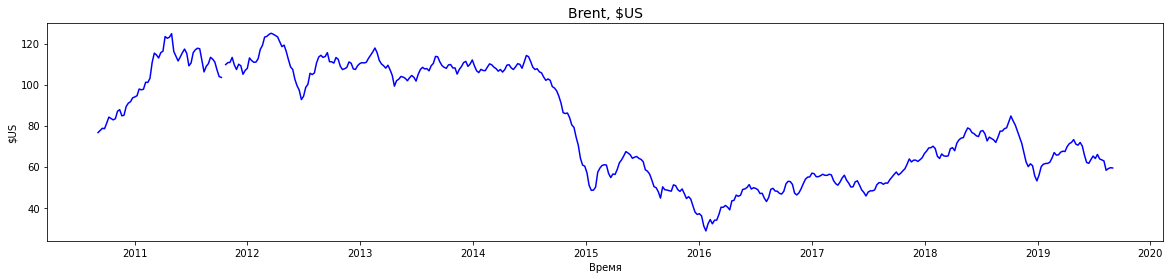

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,diff_1
Дата,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.0,3.0,3.0,246.0,35.0,4.0,0.000000,0.2,0.000000,-0.065000
2010-09-12,77.673333,2010.0,9.0,8.5,3.0,251.5,36.0,2.5,0.166667,0.0,0.166667,-0.288333


In [8]:
data_w = data.resample('W').mean()
title_str = 'Brent, $US', '$US'
plot_target(data_w, title_str)
data_w.head(2)

#### Отбор релевантных признаков

In [9]:
data_w = data_w[['Значение', 'year', 'month', 'quarter', 'weekofyear', 'diff_1']]
data_w.head(2)

,Значение,year,month,quarter,weekofyear,diff_1
Дата,,,,,,
2010-09-05,76.616000,2010.0,9.0,3.0,35.0,-0.065000
2010-09-12,77.673333,2010.0,9.0,3.0,36.0,-0.288333


### Задание 3.
Добавьте первые разности по стоимости доллара и евро к рублю.

#### Евро

In [10]:
file_name = 'R_E01_09_2010_T01_09_2019.xlsx'
data_eu = pd.read_excel(PATH + file_name, index_col=[0], parse_dates=[0]).sort_index()
print(data_eu.shape)
data_eu.head(2)

(2228, 3)


,data,curs,cdx
nominal,,,
1,2010-09-01,39.0127,Евро
1,2010-09-02,39.1654,Евро


Augmented Dickey–Fuller тест: 0.074, 0.13


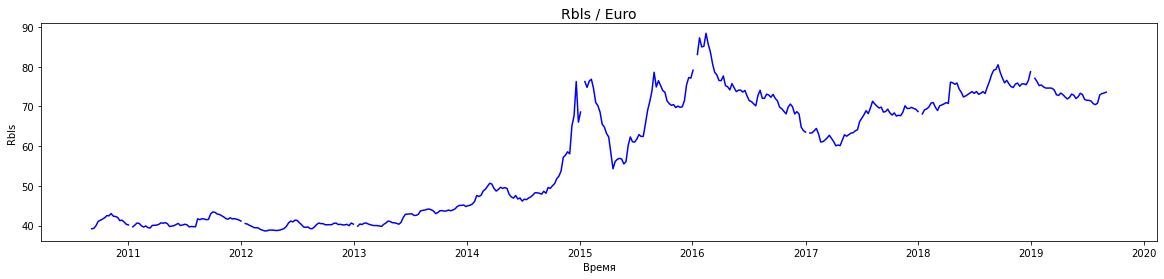

In [11]:
data_eu = data_eu.set_index('data').drop('cdx', axis=1)
data_eu.columns = ['euro']
TARGET_NAME = 'euro'
data_eu = data_eu.resample('W').mean()
title_str = 'Rbls / Euro', 'Rbls'
plot_target(data_eu, title_str)

In [12]:
data_eu.loc[1:, 'euro_diff_1'] = data_eu[TARGET_NAME][:-1].values - data_eu[TARGET_NAME][1:].values
data_eu.head(2)

,euro,euro_diff_1
data,,
2010-09-05,39.204675,NaN
2010-09-12,39.293360,-0.088685


#### Доллар США

In [13]:
file_name = 'RC_F01_09_2010_T01_09_2019.xlsx'
data_usd = pd.read_excel(PATH + file_name, index_col=[0], parse_dates=[0]).sort_index()
print(data_usd.shape)
data_usd.head(2)

(2228, 3)


,data,curs,cdx
nominal,,,
1,2010-09-01,30.8669,Доллар США
1,2010-09-02,30.8001,Доллар США


Augmented Dickey–Fuller тест: 0.291, 0.387


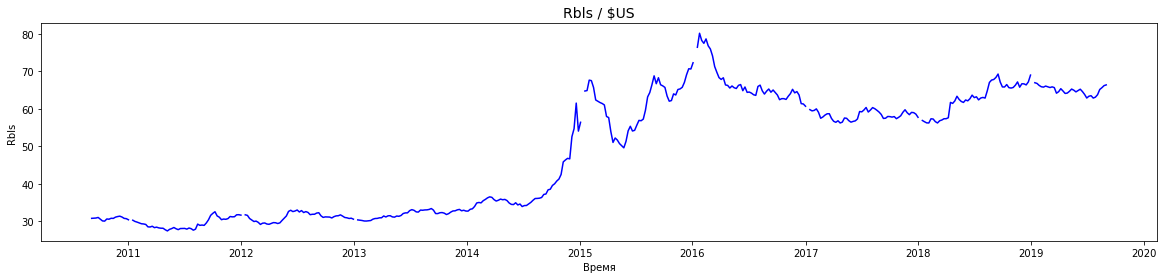

In [14]:
data_usd = data_usd.set_index('data').drop('cdx', axis=1)
data_usd.columns = ['usd']
TARGET_NAME = 'usd'
data_usd = data_usd.resample('W').mean()
title_str = 'Rbls / $US', 'Rbls'
plot_target(data_usd, title_str)

In [15]:
data_usd.loc[1:, 'usd_diff_1'] = data_usd[TARGET_NAME][:-1].values - data_usd[TARGET_NAME][1:].values
data_usd.head(2)

,usd,usd_diff_1
data,,
2010-09-05,30.76125,NaN
2010-09-12,30.79402,-0.03277


In [16]:
data_w = pd.concat([data_w, data_usd.usd_diff_1, data_eu.euro_diff_1], axis=1)
TARGET_NAME = 'Значение'
data_w.head(2)

,Значение,year,month,quarter,weekofyear,diff_1,usd_diff_1,euro_diff_1
Дата,,,,,,,,
2010-09-05,76.616000,2010.0,9.0,3.0,35.0,-0.065000,NaN,NaN
2010-09-12,77.673333,2010.0,9.0,3.0,36.0,-0.288333,-0.03277,-0.088685


### Задание 4.
Постройте модель предсказания 1-й точки от текущей (h=1).

In [17]:
t = 100 #отступ

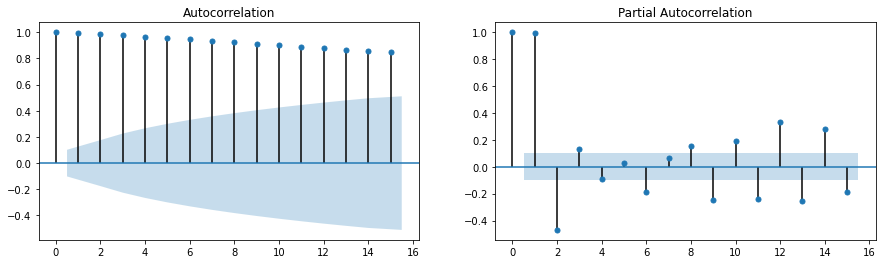

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
lag = 15

sm.graphics.tsa.plot_acf(data_w[TARGET_NAME].values[t:], lags=lag, ax=axes[0])
sm.graphics.tsa.plot_pacf(data_w[TARGET_NAME].values[t:], lags=lag, ax=axes[1])
plt.show()

#### Генерация новых признаков

In [19]:
data_w.loc[1:, 'diff_1'] = data_w[TARGET_NAME][:-1].values - data_w[TARGET_NAME][1:].values
data_w.loc[2:, 'diff_2'] = data_w[TARGET_NAME][:-2].values - data_w[TARGET_NAME][2:].values
data_w = data_w.fillna(0)
data_w.head(2)

,Значение,year,month,quarter,weekofyear,diff_1,usd_diff_1,euro_diff_1,diff_2
Дата,,,,,,,,,
2010-09-05,76.616000,2010.0,9.0,3.0,35.0,-0.065000,0.00000,0.000000,0.0
2010-09-12,77.673333,2010.0,9.0,3.0,36.0,-1.057333,-0.03277,-0.088685,0.0


In [20]:
INEPENDENT_VARIABLE_NAMES = data_w.columns[1:]

#### Разделение данных на обучающую и тестовую выборку

In [21]:
def train_test_split(data, split_date, h=1):
    ind = data.index
    
    X = data.loc[ind[:-h], INEPENDENT_VARIABLE_NAMES]    
    y = data.loc[ind[h:], TARGET_NAME]    
    
    df = X
    df.loc[:, TARGET_NAME] = y.values
    
    df_train = df[df.index.get_level_values('Дата') < split_date]
    df_test = df[df.index.get_level_values('Дата') >= split_date]    
    
    return df_train, df_test

In [22]:
split_date = '2018-02-02'
df_train, df_test = train_test_split(data_w, split_date)

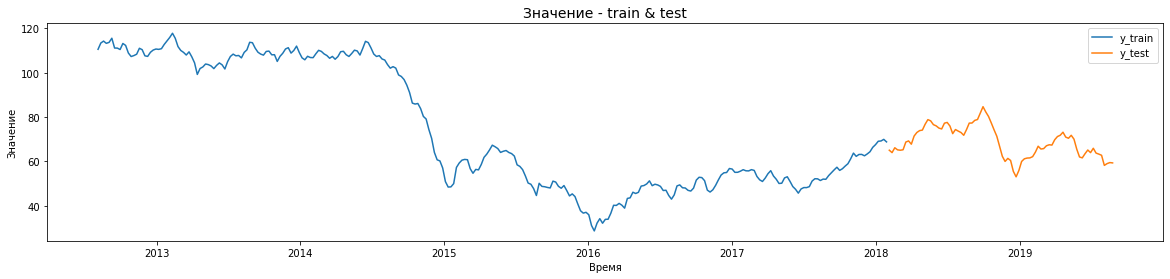

In [23]:
plt.figure( figsize=(20, 4))
plt.xlabel('Время')
plt.ylabel(TARGET_NAME)
plt.plot(df_train.index[t:], df_train[TARGET_NAME][t:], label='y_train' )
plt.plot(df_test.index, df_test[TARGET_NAME], label='y_test')
plt.title(f'{TARGET_NAME} - train & test', size=14)
plt.legend()
plt.show()

#### Отбор признаков

In [24]:
def select_variables(X, y, k_best=5, percentile=10):
    cols = X.columns
    
    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(X))
    y = scaler.fit_transform(np.array(y).reshape(-1, 1))       
    
    f_test, _ = f_regression(X, y)
    f_test /= np.max(f_test)

    # KBest
    sfk = SelectKBest(f_regression, k=k_best)
    sfk.fit_transform(X, y)    
    set_1 = list(cols[sfk.get_support()])

    # Percentile
    sfp = SelectPercentile(f_regression, percentile=percentile)
    sfp.fit_transform(X, y)    
    set_2 = list(cols[sfp.get_support()])

    # Model
    model_gb = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100)
    model_gb.fit(X, y.ravel())

    sfm = SelectFromModel(model_gb,  max_features=k_best)
    sfm.fit(X, y.ravel())
    sfm.transform(X)    
    set_3 = list(cols[sfm.get_support()])

    
    return list(set(set_1 + set_2 + set_3))

In [25]:
SELECTED_VARIABLE_NAMES = select_variables(df_train[INEPENDENT_VARIABLE_NAMES], df_train[TARGET_NAME])
SELECTED_VARIABLE_NAMES

['diff_2', 'month', 'quarter', 'diff_1', 'year']

Признаки usd_diff_1	и euro_diff_1 не отобрались. Добавим их принудительно:

In [26]:
SELECTED_VARIABLE_NAMES += ['usd_diff_1', 'euro_diff_1']

#### Модель

In [27]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
def plot_predictions(y, y_pred):
    plt.figure( figsize=(15, 4))

    plt.xlabel('Время')
    plt.ylabel('$US')
    plt.plot(df_test.index, y_pred, label='прогноз' )
    plt.plot(df_test.index, y, label='факт')
    plt.title('Brent, $US', size=14)

    plt.legend()
    plt.show()

In [29]:
def plot_corr_with_lag(y, y_pred, lag=5):
    corr_list = [np.corrcoef(y, y_pred)[1,0]]

    for i in range(lag):
        corr = np.corrcoef(y[:-(i+1)], y_pred[(i+1):])[1,0]
        corr_list.append(corr)    

    plt.figure(figsize=(8, 4))
    plt.plot(corr_list)
    plt.xlabel('Лаг корреляции')
    plt.ylabel('Коэффициенты корреляции')
    plt.title('Корреляция цели и предсказаний с лагом просмотра', size=14)
    plt.show()

#### Прямое прогнозирование

mse:	81.863
mae:	7.401
R2:	-0.679
mape:	10.295%


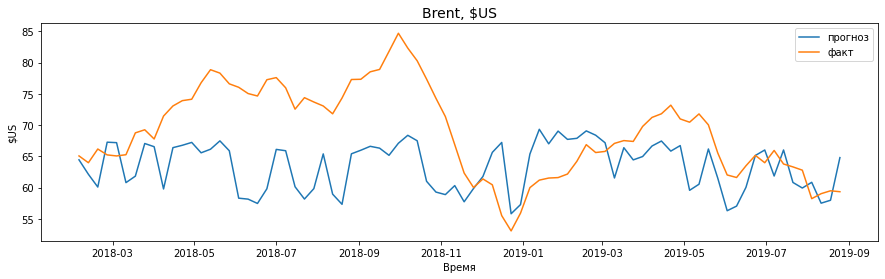

In [30]:
model_gb = GradientBoostingRegressor(max_depth=5, random_state=42, n_estimators=100)
model_gb.fit(df_train[SELECTED_VARIABLE_NAMES], df_train[TARGET_NAME])

y_pred = model_gb.predict(df_test[SELECTED_VARIABLE_NAMES])

y = df_test[TARGET_NAME]
mse = mean_squared_error(y, y_pred) 
mae = mean_absolute_error(y, y_pred) 
R2 = r2_score(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)
print(f'mse:\t{round(mse, 3)}\nmae:\t{round(mae, 3)}\nR2:\t{round(R2, 3)}\nmape:\t{round(mape, 3)}%')

plot_predictions(y, y_pred)

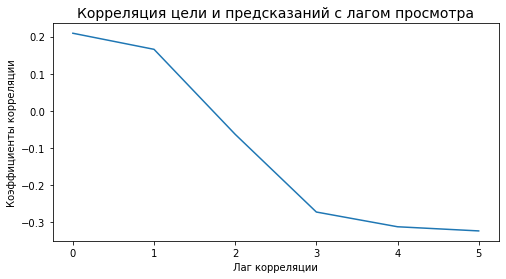

In [31]:
y = df_test[TARGET_NAME].values
plot_corr_with_lag(y, y_pred)

#### Модель предсказания 1-й точки от текущей (h=1)

In [32]:
def recalculate_df_test(ind): 
    df_test_rolling = df_test.loc[ind, [TARGET_NAME] + SELECTED_VARIABLE_NAMES] 

    for i in range(len(ind)):
        if i == 1:
            value = df_test_rolling.loc[ind[i - 1], TARGET_NAME] - df_test.loc[df_test.index[t0 - 1], TARGET_NAME] 
            df_test_rolling.loc[ind[i], 'diff_1'] = value            
            value = df_test_rolling.loc[ind[i - 1], TARGET_NAME] - df_test.loc[df_test.index[t0 - 2], TARGET_NAME]
            df_test_rolling.loc[ind[i], 'diff_2'] = value

        y_pred = model_gb.predict(pd.DataFrame(df_test_rolling.loc[ind[i], SELECTED_VARIABLE_NAMES]).T)[0]
        df_test_rolling.loc[ind[i], TARGET_NAME] = y_pred

    df_test_rolling = df_test_rolling.loc[ind[1]:, :]
    
    return df_test_rolling

In [33]:
predictions_horizon = 1
n_samples = 30
starting_points = random.sample(range(2, len(y_pred) - predictions_horizon - 1), n_samples)

results = []
for t0 in starting_points:    
    ind = df_test.index[t0 : t0 + predictions_horizon + 1]
    df_test_rolling = recalculate_df_test(ind)
    
    prediction = df_test_rolling.loc[ind[predictions_horizon], TARGET_NAME]
    actual = df_test.loc[ind[predictions_horizon], TARGET_NAME]
    
    result = abs((actual - prediction) / actual * 100)              
    results.append(result)
    
mape = np.array(results).mean()
print(f'mape = {round(mape, 3)}%')

mape = 9.816%


### Задание 5.
Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

Ошибка предсказания ряда сопоставима с ошибкой прямого прогнозирования.